# Introduction to Fuzzing

Note: A lot of the contents are taken from the [fuzzing book](https://www.fuzzingbook.org) with some modifications.


* Fuzzing is a way to automatically generate test cases in order to uncover unexpected program behaviour (e.g., crashes, memory leaks, or other types of bugs). 


* In many cases, we try to *automatically* generate *random* inputs to test a program. 


Let's install some dependencies. The code below installs the dependency in Jupyter only. A recommended way is to run "pip install fuzzingbook" on the command line.

In [1]:
import sys
!{sys.executable} -m pip install fuzzingbook

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# A Simple Random Fuzzer

Now, let's use the library provided in the fuzzingbook to get a very simple fuzzer: a random fuzzer.

In [2]:
from fuzzingbook.Fuzzer import RandomFuzzer
random_fuzzer = RandomFuzzer()
random_fuzzer.fuzz()

'!7#%"*#0=)$;%6*;>638:*>80"=</>(/*:-(2<4 !:5*6856&?""11<7+%<%7,4.8,*+&,,$,."5%<%76< -5'

The output is a randomly generated string, which can be used as an input for other programs.

We can also look at the implementation of RandomFuzzer:

In [3]:
import inspect
from fuzzingbook.fuzzingbook_utils import print_content

print_content(inspect.getsource(RandomFuzzer))

class RandomFuzzer(Fuzzer):
    def __init__(self, min_length=10, max_length=100,
                 char_start=32, char_range=32):
        """Produce strings of `min_length` to `max_length` characters
           in the range [`char_start`, `char_start` + `char_range`]"""
        self.min_length = min_length
        self.max_length = max_length
        self.char_start = char_start
        self.char_range = char_range

    def fuzz(self):
        string_length = random.randrange(self.min_length, self.max_length + 1)
        out = ""
        for i in range(0, string_length):
            out += chr(random.randrange(self.char_start,
                                        self.char_start + self.char_range))
        return out


The fuzzer simply generates a random string with a default length between 10 and 100.

## Example: Finding Buffer Overflow
Let's see how this fuzzer can be useful through a simple simulated example. In C, we often need to specify the length of the characters that we need to read. If the actual length is longer than the specified length, it can cause buffer overflow. (The example is taken from the [fuzzing book](https://www.fuzzingbook.org))

```c
char weekday[10]; // 9 characters + trailing '\0' terminator
strcpy (weekday, input);
```

We can simulate this problem in Python as: 

In [4]:
def crash_if_too_long(s):
    if len(s) > 9: # 9 characters
        raise ValueError

Now, let's generate tests for this program.

In [5]:
import traceback # to get the stack trace

trials = 100
for i in range(0, trials):
    inp = random_fuzzer.fuzz()
    print ("trial: %s with input: %s" % (i, inp))
    try: 
        crash_if_too_long(inp)
    except ValueError:
        traceback.print_exc()
        break

trial: 0 with input:  7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69':'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5''>#


Traceback (most recent call last):
  File "<ipython-input-5-9e514079d094>", line 8, in <module>
    crash_if_too_long(inp)
  File "<ipython-input-4-82d8cf6c68ac>", line 3, in crash_if_too_long
    raise ValueError
ValueError


As we can see, our very simple fuzzer is able to trigger the (simulated) bug. These kinds of bug may lead to security issues. Many companes nowadays use fuzzing to help them detect bugs.

For example, Google uses fuzzing and open sourced their fuzzing tool: [OSS Fuzz](https://github.com/google/oss-fuzz). As mentioned by Google, so far, OSS Fuzz has detected more than 14,000 bugs in 200 open source systems.

Other popular fuzzing tools include: [AFL](https://github.com/google/AFL), [LibFuzzer](https://llvm.org/docs/LibFuzzer.html), and many more. In particular, AFL is one of the most popular and most extended fuzzer. Many research papers are built upon AFL. 

## Testing a Simple URL Parser

Let's use our simple fuzzer to test a simple URL parser in Python.

In [6]:
from urllib.parse import urlparse

def http_program(url):
    supported_schemes = ["http", "https"]
    result = urlparse(url)
    if result.scheme not in supported_schemes:
        raise ValueError("Scheme must be one of " + repr(supported_schemes))
    if result.netloc == '':
        raise ValueError("Host must be non-empty")

    # Do something with the URL
    return True  

For now, we assume that our goal is to test if we can generate both valid and invliad inputs for the program. We can use the following code:

In [7]:
def is_valid_url(url):
    try:
        result = http_program(url)
        return True
    except ValueError:
        return False

Then, we use our random fuzzer to test the program. 

In [8]:
random_fuzzer = RandomFuzzer()

valid_inputs = set()
trials = 20

for i in range(trials):
    inp = random_fuzzer.fuzz()
    print ("input is " + inp)
    if is_valid_url(inp):
        valid_inputs.add(inp) 

len(valid_inputs) / trials

input is 8($37"0*80!#';1/ -6%=:80;!'% 3&$;*27%%'8&+$)0(?
input is ,-)>3=( #383'7)#(.496(<=+3717(-0((1/8)2!>?#1-3.,6,*+&$*88(%7+?,%''94?79 &,1%4+3&&;),9 !:/?*> ,4+!7#=
input is ($,)$)64>*$,*#$6;4$2*1<<,22)+6->4;'&(95(,23/"=$
input is 0;/,-',8-+!28"%+(;&#9;3)),?2%-#>=*6=?=.#?9> 1*;+"'&6: 499!?#3
input is &5;?-'**(8:>)/< 
input is 00&<4$?<:#*?!(=-2&9-4?'4)1$(4<04-(>!9'%/0<),;;.=&*/(")"#:.<-&*5;2#<$16/
input is ,%/4/>!1->#&,4.:1* "&;.:)1!$*8/(*?#
input is #3!'*;"/<";;*!6"*-2,$994,%*:"$25!2=!+!2#''6/3'4!6%7056'??2#7;75>27'1
input is #-4.?*<?6&" !3'7-5>18%55*,55&8>"86,?"/7!1%5-**&-$&)$
input is 1;"21('8"(%$4,("(&!67%89$!.?(*(96(28$=6029:<:$(6 !-+2622(&4'7
input is 9&,=4')3#..
input is 3-<49<%&*3&373'/(-*;-/#*;9 !90?
input is ):50*+-> <##/3)5,&--<+-9,%(8&5*2);) )&1!?(39'0 3"6
input is -?>0;1)/%"(
input is ,>45*$73=,"%5=+
input is 74!97175"0(/$+,7*8$-
input is '=:4!>3/$,1:# +$8#(>$150%,<6*7!&':<')7;>=>=?8=*190 &5/.)4/'++>#(,&#?+
input is ** 9;>;010!" 5=>&8>=677 2.
input is )*>8*1"677>% *$!,70%

0.0

As expected, we cannot generate any valid input to test the program. How can we generate smarter inputs?

# Mutation Fuzzer

Randomly generating inputs may not sound so smart. For different programs, we might want a more customized way to automatically generate inputs. 

For example, if we want to test a calculator program, we might not want to generate so many textual inputs. These textual inputs may only increase the test generation time with no additional code coverage (more on this later). 

Now, let's look at some simple mutation operators.

In [9]:
import random

# the code mutates the input by randomly deleting a character
def delete_random_char(s):
    if s == "":
        return s
    pos = random.randint(0, len(s) - 1)
    return s[:pos] + s[pos+1:]

inp = "This is an example"
delete_random_char(inp)

'This i an example'

In [10]:
# the code mutates the input by randomly adding a character
def add_random_char(s):
    pos = random.randint(0, len(s) - 1)
    random_character = chr(random.randrange(32, 127))
    return s[:pos] + random_character + s[pos:]

inp = "This is an example"
add_random_char(inp)

'Thiqs is an example'

In [11]:
# the code mutates the input by randomly flipping a character
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    c = s[pos]
    bit = 1 << random.randint(0, 6)
    new_c = chr(ord(c) ^ bit)
    # print("Flipping", bit, "in", repr(c) + ", giving", repr(new_c))
    return s[:pos] + new_c + s[pos + 1:]

inp = "This is an example"
flip_random_character(inp)

'Txis is an example'

We can also apply multiple mutators to an input:

In [12]:
inp = "This is an example"

mutators = [delete_random_char, add_random_char, flip_random_character]

for i in range(0, 10):
    mutator = mutators[random.randint(0, 2)]
    inp = mutator(inp)
    
# after 10 random mutations
print (inp)

his7 szn e&xa}plE


We can also use similar code to fuzz URLs for testing web servers or URL parsers (remember the example that we discussed in the previous section). 

Now, instead of using the code above, we can call the API from the FuzzingBook (the behaviour is the same):

In [13]:
from fuzzingbook.MutationFuzzer import MutationFuzzer
import random
seed = "https://www.concordia.ca/"
mutation_fuzzer = MutationFuzzer(seed=["https://www.concordia.ca/"])
mutation_fuzzer.fuzz()

[mutation_fuzzer.fuzz() for i in range(10)]


['httpqz//ww.bojordia.ca/',
 'yHttps//www.koncOrdii\x0ec/',
 'httpS://www_.concordia.c/',
 'xttxs://wwnncopdi.chi/',
 'hBtt`s://www.cknorDi7a.ca/',
 'https://wwwonc!orheia.ca/',
 'https://w.concrdica/',
 'https:/wwg.concordia.ca/',
 'htHps://w*Ow.>cmnckrdima.ca/',
 'h-tps:x/wwwf}.concordia1.ca/Q']

These automatically generated inputs look better than those randomly generated ones. We can use inputs to test the URL parser program for unexpected behvaiour (e.g., exception handling or crashes) or even security issues.

Note that for different problems, you might need to come up with different mutators. For example, if you are testing a calculator program, mutators for strings may not be very effective. 

Let's use our new fuzzer to test our URL parser.

In [14]:
seed = "http://www.concordia.ca"
mutation_fuzzer = MutationFuzzer([seed])

valid_inputs = set()
trials = 20

for i in range(trials):
    inp = mutation_fuzzer.fuzz()
    print ("input " + inp)
    if is_valid_url(inp):
        valid_inputs.add(inp) 

len(valid_inputs) / trials

input http://www.concordia.ca
input ahttp:/www*concordiA.ba
input h|ttp://Www.cnco{rdiaca
input http://ww.concnrdiaa
input ht4p://ww2w.ce.cordiaa
input http:?uw.co*cord.ca
input http:-/w.concOrdiacat
input htt://www.concrdi!.ca
input hwtp://zwww.concodia.ca
input  hlttp://sBww.conria.c
input (tt://ww.concordiacat
input h`p://www.Qconcordia.Fca
input hptp:P//w2wSu`.onc/rdia.ca
input http:/Y+/www.cn7Xncordad`.a
input http://w{ww.concorxdiaS.ca
input htTp:/ww.concordia.ca
input http:,//www.c,oncordia.ca
input http:l/wgw.cEncoria.ca
input httpF://ww>co5ncordia.ca
input ?htux://www>Concord6i`.ca


0.15

This is an improvement. We can now generate valid inputs to test the URL pareser! 

But is there any way that we can do better?

# Using Coverage to Guide Fuzzing

What we have discussed so far belongs to the family of blackbox fuzzing. Namely, we do not have any information of the source code, nor how the code is executed. We can improve our fuzzer by integrating the coverage information. 

We can easily get coverage information in Python. We can setup a trace function as follows (more information can be found [here](https://pymotw.com/3/sys/tracing.html)):

In [15]:
# record which line got executed
coverage = []

def traceit(frame, event, arg):
    if event == "line":
        global coverage
        #func_filename = frame.f_code.co_filename
        function_name = frame.f_code.co_name
        lineno = frame.f_lineno
        #coverage.append((func_filename, function_name, lineno))
        coverage.append((function_name, lineno))

    return traceit

In [16]:
import sys

def execute_and_trace(fun, inp):
    global coverage
    coverage = []
    sys.settrace(traceit)  # Turn on
    fun(inp)
    sys.settrace(None)    # Turn off

inp = "http://www.concordia.ca"
execute_and_trace(is_valid_url, inp)
[cov for cov in coverage]

[('is_valid_url', 2),
 ('is_valid_url', 3),
 ('http_program', 4),
 ('http_program', 5),
 ('urlparse', 367),
 ('_coerce_args', 115),
 ('_coerce_args', 116),
 ('_coerce_args', 119),
 ('_coerce_args', 116),
 ('_coerce_args', 121),
 ('_coerce_args', 122),
 ('urlparse', 368),
 ('urlsplit', 400),
 ('_coerce_args', 115),
 ('_coerce_args', 116),
 ('_coerce_args', 119),
 ('_coerce_args', 116),
 ('_coerce_args', 121),
 ('_coerce_args', 122),
 ('urlsplit', 401),
 ('urlsplit', 402),
 ('urlsplit', 403),
 ('urlsplit', 404),
 ('urlsplit', 406),
 ('urlsplit', 408),
 ('urlsplit', 409),
 ('urlsplit', 410),
 ('urlsplit', 411),
 ('urlsplit', 412),
 ('urlsplit', 413),
 ('urlsplit', 414),
 ('urlsplit', 415),
 ('_splitnetloc', 387),
 ('_splitnetloc', 388),
 ('_splitnetloc', 389),
 ('_splitnetloc', 390),
 ('_splitnetloc', 388),
 ('_splitnetloc', 389),
 ('_splitnetloc', 390),
 ('_splitnetloc', 388),
 ('_splitnetloc', 389),
 ('_splitnetloc', 390),
 ('_splitnetloc', 388),
 ('_splitnetloc', 392),
 ('urlsplit', 41

We can also use the *Coverage* class from the fuzzing book to achieve the same goal. The code in the fuzzing book simply abstracts the above-mentioned code. 

In [17]:
from fuzzingbook.Coverage import Coverage

inp = "http://www.concordia.ca"

with Coverage() as cov:
    is_valid_url(inp)
    
[c for c in cov.coverage()]

[('is_valid_url', 3),
 ('urlparse', 370),
 ('urlsplit', 402),
 ('_coerce_args', 122),
 ('http_program', 6),
 ('urlparse', 374),
 ('is_valid_url', 2),
 ('_coerce_args', 115),
 ('_coerce_args', 119),
 ('urlsplit', 403),
 ('urlparse', 375),
 ('http_program', 12),
 ('__new__', 14),
 ('http_program', 5),
 ('urlparse', 368),
 ('urlsplit', 404),
 ('_coerce_args', 116),
 ('urlsplit', 400),
 ('http_program', 4),
 ('urlparse', 369),
 ('urlsplit', 405),
 ('http_program', 8),
 ('urlparse', 367),
 ('is_valid_url', 4),
 ('urlparse', 373),
 ('__exit__', 237),
 ('urlsplit', 401),
 ('_coerce_args', 121),
 ('_noop', 99)]

How can the coverage information help us during fuzzing? Let's look at the example below. 

In [18]:
with Coverage() as first_cov:
    is_valid_url("http://www.concordia.ca")
with Coverage() as second_cov:
    # the URL of searching "google" on Google
    is_valid_url("https://www.google.com/search?q=google&rlz=1C5CHFA_enCA758CA758&oq=google&aqs=chrome..69i57j69i60l3j69i65j69i60.4544j0j7&sourceid=chrome&ie=UTF-8")
    
first_cov.coverage() - second_cov.coverage()

{('urlsplit', 405)}

The coverage information for different inputs may be different! Let's see the relationship between input and coverage. 

In [19]:
def calculate_cumulative_coverage(input_population, function):
    cumulative_coverage = []
    all_coverage = set()
    
    for inp in input_population:
        with Coverage() as cov:
            try:
                function(inp)
            except:
                # we ignore exceptions for the purpose of this code, but some exceptions may be interesting
                pass
        # set union
        all_coverage |= cov.coverage()
        cumulative_coverage.append(len(all_coverage))
    return cumulative_coverage

The above code measures the cumulative coverage for a set of inputs (i.e., input_population). Let's test this code by doing some simple fuzzing. 

In [20]:
trials = 20
fuzzer = MutationFuzzer(seed = ["http://www.concordia.ca"])

population = []
for i in range(0, trials):
    population.append(fuzzer.fuzz())

cumulative_coverage = calculate_cumulative_coverage(population, is_valid_url)
cumulative_coverage

[29,
 45,
 58,
 66,
 66,
 67,
 70,
 70,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 78,
 78,
 78]

We can also visualize the cumulative coverage.

Text(0,0.5,'lines covered')

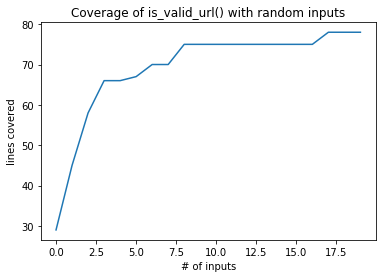

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cumulative_coverage)
plt.title('Coverage of is_valid_url() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')